# Michel Electron Selection and Reconstruction

Michel electrons come out of a muon decay. They are electrons, so they look like a lower energy electromagnetic shower attached to the end of a stopping muon track.


## I. Motivation

Michel electrons are used in LArTPC experiments as “standard candles”: we understand their energy spectrum very well, so they can be used to calibrate the detector and to compare the quality of different detectors. The Michel electron spectrum is one of the first “tokens” that an experiment will show to prove that the detector is running and we can successfully reconstruct the data. Since their energy is in a range up to ~50MeV, they are also representative of the detector response to electromagnetic particles generated by low energy neutrino activity.



### What are we looking for?

The primary Michel electron that comes out of the muon decay-at-rest can lose energy either through ionization (collision stopping power), or through the production of radiative photons via Bremsstrahlung (radiative stopping power). Beyond a certain energy, the radiative stopping power is greater than the collision stopping power. If the radiative photons have enough energy, they can pair-produce, i.e. turn into an electron-positron pair. They, in turn, can produce new radiative photons, and so on. They can also undergo Compton scattering. A cascade of electrons and photons (electromagnetic shower) happens.

<figure>
<img src="./electron_stopping_power.png" style="width:50%">
<figcaption align = "center"> Energy loss per unit distance (MeV/cm) for electrons traveling in liquid argon </figcaption>
</figure>

Ionization produces track-like energy depositions, whereas the photons can travel some distance before converting into a secondary electron. Hence Michel electrons have two clear topological features: a primary ionization, which is track-like at the end of the muon track, and some scattered energy deposits much further away which come from these radiative photons.

<figure>
<img src="./michel.png" style="width:50%">
<figcaption align = "center"> Example of Michel electron topology </figcaption>
</figure>



## II. Setup

We first need to set the working environment and the path to the dataset.

In [1]:
import sys
%pip install --user --upgrade spine-ml
#%pip uninstall anywidget
#import spine
#SOFTWARE_DIR = '/global/cfs/cdirs/m5252/dune/spine/prod/protodune-vd/jobs/20260131_090226_spine_protodune-vd_full_chain_260128/output/' # Change this path to your software install
#DATA_DIR = '/global/cfs/cdirs/m5252/dune/spine/prod/protodune-vd/jobs/20260131_090226_spine_protodune-vd_full_chain_260128/output/' # Change this path if you are not on SDF (see main README)
SOFTWARE_DIR = '/global/cfs/cdirs/m5252/software/spine' 
# Set software directory
sys.path.append(SOFTWARE_DIR)
# If you did not install SPINE locally, do:
#!export PYTHON_PATH={SOFTWARE_DIR}
#!python3 {SOFTWARE_DIR}/bin/run.py -h
#%pip install --user --upgrade plotly
#%pip install --user --upgrade anywidget


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Also, let's import some libraries

In [2]:
DATA_DIR = '/global/cfs/cdirs/m5252/dune/spine/prod/protodune-vd/data/beam_test/jobs/20260204_144511_spine_protodune-vd_full_chain_260128/output/' # Change this path if you are not on SDF (see main README)
import numpy as np
import math
import pandas as pd
from collections import OrderedDict

from scipy.spatial.distance import cdist

Now pass the analysis configuration

In [3]:
import yaml

DATA_PATH = DATA_DIR + '*.h5'
DETECTOR = 'protodune-vd'

cfg = '''
# Load HDF5 files
io:
  reader:
    name: hdf5
    file_keys: DATA_PATH
geo:
  detector: DETECTOR
    
# Build reconstruction output representations
build:
  mode: reco
  units: cm
  fragments: false
  particles: true
  interactions: true
'''.replace('DATA_PATH', DATA_PATH).replace('DETECTOR',DETECTOR)

cfg = yaml.safe_load(cfg)


Now initialize the driver with this configuration

In [4]:
from spine.driver import Driver

driver = Driver(cfg)

Welcome to JupyROOT 6.26/16

 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.9.5

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux login02 5.14.21-150500.55.97_13.0.78-cray_shasta_c #1 SMP Thu Mar 13 20:09:44 UTC 2025 (330b47d) x86_64 x86_64 x86_64 GNU/Linux

base: {world_size: 0, seed: 1770485139}
io:
  reader: {name: hdf5, file_keys: /global/cfs/cdirs/m5252/dune/spine/prod/protodune-vd/data/beam_test/jobs/20260204_144511_spine_protodune-vd_full_chain_260128/output/*.h5}
geo: {detector: protodune-vd}
build: {mode: reco, units: cm, fragments: false, particles: true, interactions: true}

Will load 10 file(s):
 - /global/cfs/cdirs/m5252/dune/spine/prod/protodune-vd/data/beam_test/jobs/20260204_144511_sp

Let's get the first entry

In [11]:
ENTRY = 1
data = driver.process(entry=ENTRY)

Let's get reconstructed/truth particles

In [12]:
reco_particles     = data['reco_particles']
#truth_particles    = data['truth_particles']

Let's import michel shape and track shape from spine.utils.globals

In [13]:
from spine.utils.globals import SHAPE_LABELS, MICHL_SHP, TRACK_SHP

In [14]:
print(SHAPE_LABELS)

{-1: 'Unknown', 0: 'Shower', 1: 'Track', 2: 'Michel', 3: 'Delta', 4: 'LE', 5: 'Ghost', 6: 'Unknown'}


In [15]:
print(MICHL_SHP, TRACK_SHP)

2 1


Let's see if this entry has Michels

In [16]:
print('Number of reconstructed Michel:', np.sum(np.array([p.shape for p in reco_particles]) == MICHL_SHP))
#print('Number of true Michel:', np.sum(np.array([p.shape for p in truth_particles]) == MICHL_SHP))

Number of reconstructed Michel: 2


## III. Selecting Michel Electrons

Let's draw Michels in this entry.

In [21]:
from spine.vis import Drawer
import plotly
drawer = Drawer(data,draw_mode="reco") # Try to replace none with 'icarus', 'sbnd' or '2x2'!

# With 'shape' option, the color indicdates particle shape
fig = drawer.get('particles', 'shape', draw_end_points=False, draw_vertices=False) 

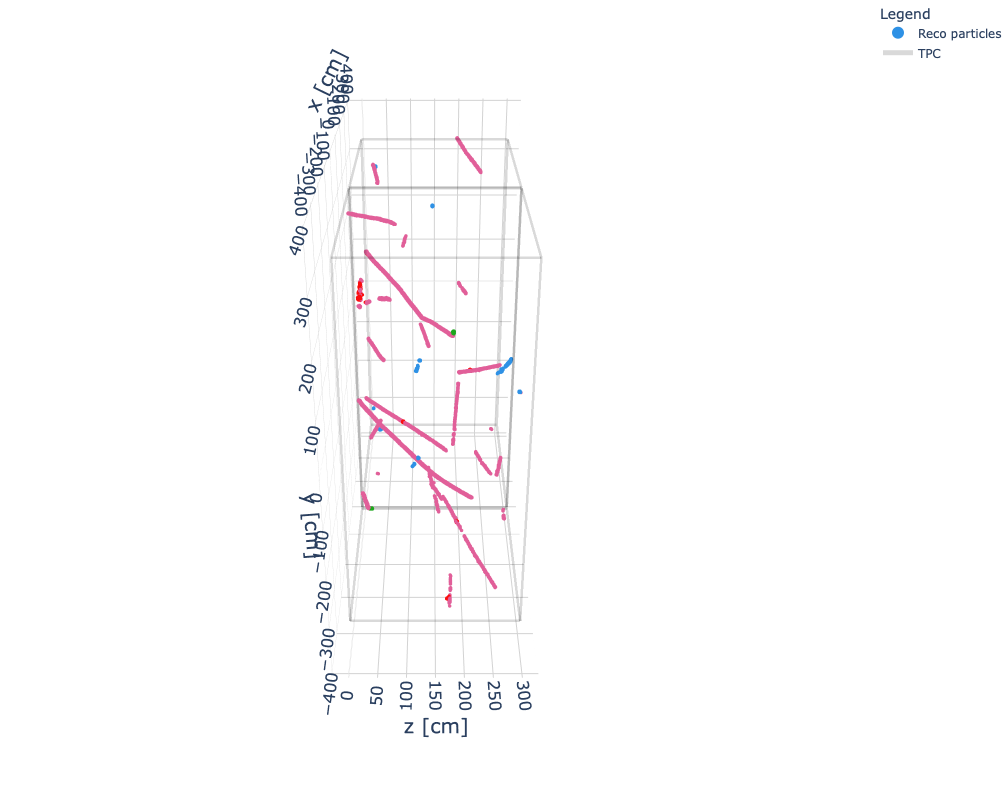

In [23]:
fig.show()

### Selecting Michel candidates
**Criteria 1: closeness of Michel and track end point**
To check if our candidate michel is actually adjacent to a track, we will set a minimum distance threshold (`attached_threshold`) between the Michel electron and the end point of the track within the same interaction.


In [24]:
# Selection parameters
muon_min_voxel_count=20
attach_threshold = 2
match_threshold = 0.5

### Finding true Michels

Let's find true Michels first. 


In [14]:
def fill_true_michels(it, truth_particles, true_michels,reco_particles):
    
    # it: entry number, iteration
    # truth_particles: truth_particles
    # true_michels: output list of ordered dictionary of true michels
    
    for tp in truth_particles:
        if tp.shape != MICHL_SHP: continue
        is_contained = tp.is_contained                                                                                           
        michl_start = tp.start_point
        int_id = tp.interaction_id
        is_attached = False
        
        d = math.inf
        for tp2 in truth_particles:
            if tp2.interaction_id != int_id: continue
            if tp2.shape != TRACK_SHP: continue
            if tp2.size < muon_min_voxel_count: continue

            muon_end = tp2.end_point
            distances = cdist(tp.points, tp2.points)
            d = np.min(distances)
            #d = min(d, np.linalg.norm(michl_start-muon_end))
            if d < attach_threshold:
                is_attached = True
                true_mu = tp2
                break
                
        test_dict={
                    'index': it,
                    'id': tp.id,
                    'attach_dist': d,
                    'is_attached': is_attached,
                    'is_contained': is_contained,
                    'is_matched': tp.is_matched,
                    'pred_num_pix': -1,
                    'match_ids': tp.match_ids,
                    'match_overlaps': tp.match_overlaps,
                    'ke': tp.ke
                }
        for i in range(len(tp.match_ids)):
            if tp.match_overlaps[i]>match_threshold: # match_threshold is set to 0.5
                pred_id = tp.match_ids[i]
                for p in reco_particles:
                    if p.id == pred_id:
                        m = p
                        test_dict.update({
                            "pred_num_pix": m.size,
                        })
        true_michels.append(OrderedDict(test_dict))

In [15]:
true_michels = []
fill_true_michels(ENTRY, truth_particles, true_michels,reco_particles)

In [16]:
true_michels

[OrderedDict([('index', 2),
              ('id', np.int64(43)),
              ('attach_dist', np.float64(0.764984130859375)),
              ('is_attached', True),
              ('is_contained', True),
              ('is_matched', True),
              ('pred_num_pix', 56),
              ('match_ids', array([31])),
              ('match_overlaps', array([0.8214286], dtype=float32)),
              ('ke', np.float64(50.734375685785345))]),
 OrderedDict([('index', 2),
              ('id', np.int64(44)),
              ('attach_dist', np.float64(0.764984130859375)),
              ('is_attached', True),
              ('is_contained', False),
              ('is_matched', True),
              ('pred_num_pix', 46),
              ('match_ids', array([27, 28])),
              ('match_overlaps',
               array([0.7708333 , 0.01098901], dtype=float32)),
              ('ke', np.float64(52.222656642274885))]),
 OrderedDict([('index', 2),
              ('id', np.int64(49)),
              ('attach_

### Finding reco Michels

For reco Michels, we want to save more information than true_michels.\
If there exists a reco-to-true-matching over the matching threshold, matched true information is also saved.

In [25]:
def fill_michels(it, reco_particles, michels):
    
    # it: entry number, iteration
    # michels: output list of ordered dictionary of michels

    for p in reco_particles:
        muon = None
        if p.shape != MICHL_SHP: continue
        is_contained = p.is_contained
        michl_start = p.start_point
        int_id = p.interaction_id
        is_attached = False

        d = math.inf
        for p2 in reco_particles:
            if p2.interaction_id != int_id: continue
            if p2.shape != TRACK_SHP: continue
            if p2.size < muon_min_voxel_count: continue

            muon_end = p2.end_point
            distances = cdist(p.points, p2.points)
            d = np.min(distances)
            #d = min(d, np.linalg.norm(michl_start-muon_end))
            if d < attach_threshold:
                is_attached = True
                muon = p2
                break

        # Record candidate Michel                                                                                                                                       
        update_dict={
                'index': it,
                'id': p.id,
                "attach_dist": d,
                "is_attached": is_attached,
                "is_contained": is_contained,
                'is_matched': p.is_matched,
                'match_ids': p.match_ids,
                'match_overlaps': p.match_overlaps,
                "pred_num_pix": p.size,
                "pred_sum_pix": p.depositions.sum(), 
                "true_num_pix": -1,
                "true_sum_pix": -1,
                'ke': p.ke,
                'true_ke': -1,
                }
        
        
        michels.append(OrderedDict(update_dict))

In [27]:
michels = []
#michels_it = [part for part in truth_particles if part.shape==MICHL_SHP]
fill_michels(ENTRY, reco_particles, michels)

In [28]:
michels

[OrderedDict([('index', 1),
              ('id', np.int64(17)),
              ('attach_dist', np.float64(3.2456319223438945)),
              ('is_attached', False),
              ('is_contained', False),
              ('is_matched', False),
              ('match_ids', array([], dtype=int64)),
              ('match_overlaps', array([], dtype=float32)),
              ('pred_num_pix', 61),
              ('pred_sum_pix', np.float32(31.113937)),
              ('true_num_pix', -1),
              ('true_sum_pix', -1),
              ('ke', np.float32(38.453716)),
              ('true_ke', -1)]),
 OrderedDict([('index', 1),
              ('id', np.int64(25)),
              ('attach_dist', np.float64(0.7650032043457031)),
              ('is_attached', True),
              ('is_contained', False),
              ('is_matched', False),
              ('match_ids', array([], dtype=int64)),
              ('match_overlaps', array([], dtype=float32)),
              ('pred_num_pix', 32),
              ('

We found a Michel and the matched true Michel!

## IV. Repeating with high stat

It's convinient to save [michels, true_michels] to csv.\
I ran below 3 cells to generate csvs with 50 images.

In [30]:
michels, true_michels = [], []

from tqdm import tqdm
n_samples =len(driver)
for iteration in tqdm(range(n_samples)):
    data = driver.process(entry=iteration)
    
    reco_particles     = data['reco_particles']
    #truth_particles    = data['truth_particles'] 

    #selected_michels = get_michels(reco_particles)
    #fill_true_michels(iteration, truth_particles, true_michels,reco_particles)
    fill_michels(iteration, reco_particles, michels)#, matched_t2r)

    #fill_michels(michels_it, true_michels_it, matched_r2t, matched_t2r)
michels_df = pd.DataFrame([michels[i] for i, j in enumerate(michels)])
#true_michels_df = pd.DataFrame([true_michels[i] for i, j in enumerate(true_michels)])

100%|██████████| 180/180 [00:04<00:00, 44.84it/s]


In [31]:
michels_df.to_csv('michels_data.csv')
#true_michels_df.to_csv('true_michels_cosmic.csv')

Now let's load from those csvs.

In [35]:
michels_hs = pd.read_csv('michels_data.csv')
#true_michels_hs = pd.read_csv('true_michels_cosmic.csv')

Let's take a look at 'michels_hs'

In [36]:
michels_hs.head(10)

,Unnamed: 0,index,id,attach_dist,is_attached,is_contained,is_matched,match_ids,match_overlaps,pred_num_pix,pred_sum_pix,true_num_pix,true_sum_pix,ke,true_ke
0,0,0,11,0.764999,True,True,False,[],[],72,52.181390,-1,-1,64.490980,-1
1,1,0,24,0.764984,True,False,False,[],[],2,1.262084,-1,-1,1.559810,-1
2,2,0,29,0.764954,True,False,False,[],[],6,2.449723,-1,-1,3.027612,-1
3,3,0,35,0.764984,True,True,False,[],[],1,0.518241,-1,-1,0.640494,-1
4,4,1,17,3.245632,False,False,False,[],[],61,31.113937,-1,-1,38.453716,-1
5,5,1,25,0.765003,True,False,False,[],[],32,7.707034,-1,-1,9.525124,-1
6,6,3,19,0.764999,True,True,False,[],[],25,26.402235,-1,-1,32.630524,-1
7,7,3,39,0.764984,True,True,False,[],[],70,30.059088,-1,-1,37.150030,-1
8,8,3,41,0.764954,True,True,False,[],[],6,3.627369,-1,-1,4.483065,-1
9,9,3,46,1.081883,True,False,False,[],[],9,9.856463,-1,-1,12.181603,-1


We'll apply some cuts on selected Michels and see how the efficiency/purity change.

In [37]:
# no cut

N_pred = michels_hs.shape[0] # count reconstructed michels
#N_matched = np.count_nonzero(michels_hs['true_num_pix'] > -1) # count matched michels
#N_true = true_michels_hs.shape[0] # count true michels
#N_matched_k = np.count_nonzero(true_michels_hs['pred_num_pix'] > -1)
print("Number of predicted candidate Michel electrons = ", N_pred)
#print("Number of matched predicted candidate Michel electrons = ", N_matched)
#print("Number of matched true Michel electrons = ",N_matched_k)
#print("Number of true Michel electrons = ", N_true)
#print("Identification purity = %.2f %%" % (100* N_matched / N_pred))
#print("Identification efficiency = %.2f %%" % (100 * N_matched / N_true))

Number of predicted candidate Michel electrons =  466


In [38]:
# 0-th cut
# reco. michel is larger than 8 voxels

michels_hs_0 = michels_hs[(michels_hs['pred_num_pix']>=8)] 
N_pred_0 = michels_hs_0.shape[0]
#N_matched_0 = np.count_nonzero(michels_hs_0['true_num_pix'] > -1)
#N_true = true_michels_hs.shape[0]
#N_matched_t = np.count_nonzero(true_michels_hs['pred_num_pix'] > -1)
print("Number of predicted candidate Michel electrons = ", N_pred_0)
#print("Number of matched predicted candidate Michel electrons = ", N_matched_0)
#print("Number of matched true Michel electrons = ",N_matched_t)
#print("Number of true Michel electrons = ", N_true)
#print("Identification purity = %.2f %%" % (100* N_matched_0 / N_pred_0))
#print("Identification efficiency = %.2f %%" % (100 * N_matched_0 / N_true))

Number of predicted candidate Michel electrons =  400


In [39]:
# 1-th cut
# reco. michel and true michels are attached to tracks within threshold. 

michels_hs_1 = michels_hs_0[michels_hs_0['is_attached']==True]
N_pred_1 = michels_hs_1.shape[0]
#N_matched_1 = np.count_nonzero(michels_hs_1['true_num_pix'] > -1)
#true_michel_hs_1 = true_michels_hs[true_michels_hs['is_attached']==True]
#N_true_1 = true_michels_hs[true_michels_hs['is_attached']==True].shape[0]
#N_matched_2 = np.count_nonzero(true_michel_hs_1['pred_num_pix'] > -1)
print("Number of predicted candidate Michel electrons = ", N_pred_1)
#print("Number of matched predicted candidate Michel electrons = ", N_matched_1)
#print("Number of matched true Michel electrons = ", N_matched_2)
#print("Number of true Michel electrons = ", N_true_1)
#print("Identification purity = %.2f %%" % (100* N_matched_1 / N_pred_1))
#print("Identification efficiency = %.2f %%" % (100 * N_matched_1 / N_true))

Number of predicted candidate Michel electrons =  319
